In [1]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# inspect the measurement class
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [7]:
# inspect the station class
inspector = inspect(engine)
columns = inspector.get_columns('station')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [8]:
# Save references to each table
foundClassesMeasurement = Base.classes.measurement
foundClassesStation = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
session.query(foundClassesMeasurement.date).order_by(foundClassesMeasurement.date.desc()).first()

('2017-08-23',)

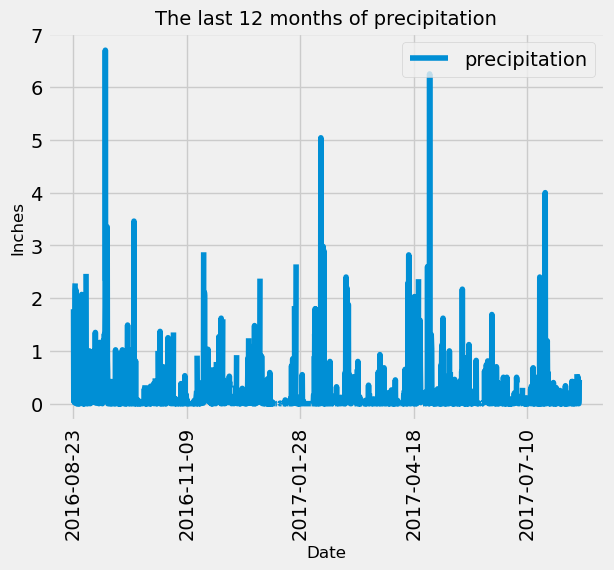

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
oneYear = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
datesQuery = session.query(foundClassesMeasurement.date,foundClassesMeasurement.prcp
                          ).filter(foundClassesMeasurement.date >= (dt.date(2017,8,23) - dt.timedelta(days=365))).all()    

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(datesQuery)

#set the date column as the index
dfSorted = df.set_index("date") 

# Sort the dataframe by date
dfSorted = dfSorted.sort_values("date") 

# Use Pandas Plotting with Matplotlib to plot the data
plot = dfSorted.plot()
plt.title("The last 12 months of precipitation", fontsize = 14)
plt.ylabel("Inches" , fontsize = 12)
plt.xlabel("Date", fontsize = 12)
plt.xticks(rotation = 90)
plt.legend(['precipitation'],loc='upper right')
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
dfSorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
stationQuery = session.query(func.count(foundClassesStation.station.distinct())).all()
stationQuery

[(9,)]

In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
mostStationQuery = session.query(foundClassesMeasurement.station,func.count(foundClassesMeasurement.station)
                            ).group_by(foundClassesMeasurement.station).order_by(func.count(foundClassesMeasurement.station
                                                                                           ).desc()).all()
mostStationQuery

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostStationTemp = session.query(foundClassesMeasurement.station,func.min(foundClassesMeasurement.tobs
                                                                        ),func.max(foundClassesMeasurement.tobs
                                                                                  ),func.avg(foundClassesMeasurement.tobs)
                               ).filter(foundClassesMeasurement.station == 'USC00519281').all()
mostStationTemp

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

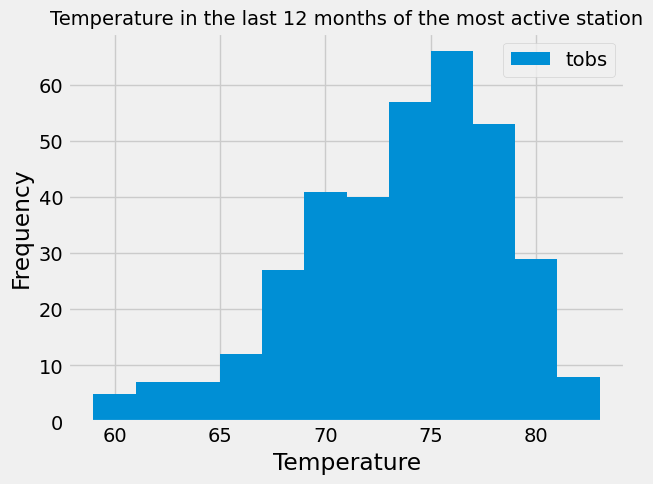

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostStation = session.query(foundClassesMeasurement.date,foundClassesMeasurement.tobs
                           ).filter(foundClassesMeasurement.date >= oneYear
                                   ).filter(foundClassesMeasurement.station == 'USC00519281').all()
mostStationdf = pd.DataFrame(mostStation)
mostStationdfPlot = mostStationdf.plot.hist(bins=12)
plt.title("Temperature in the last 12 months of the most active station", fontsize = 14)
plt.xlabel("Temperature")
plt.show()

# Close session

In [25]:
# Close Session
session.close()